In [39]:
# pip install tensorflow
# pip install alpha_vantage
import warnings
warnings.filterwarnings("ignore")

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
from alpha_vantage.foreignexchange import ForeignExchange 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import timedelta

In [132]:
api_key = "968U93YONJTBSCFS"   #My Api Key
fx = ForeignExchange(key= "api_key", output_format="pandas")  # Initialize the ForeignExchange class

In [133]:
# Get the daily exchange rates
original_data, meta_data = fx.get_currency_exchange_daily(from_symbol="USD", to_symbol="KES", outputsize="full")

In [134]:
# Renaming columns
original_data.rename(columns={
    "1. open": "Open",
    "2. high": "High",
    "3. low": "Low",
    "4. close": "Close"
}, inplace=True)

In [135]:
original_data.index = pd.to_datetime(original_data.index)  # Convert index to datetime
original_data = original_data.sort_index() 

In [136]:
data = original_data

In [137]:
data.head()

,Open,High,Low,Close
date,,,,
2014-11-07,89.70,89.75,89.60,89.70
2014-11-10,89.70,89.75,89.60,89.75
2014-11-11,89.95,89.95,89.95,89.95
2014-11-12,89.95,90.05,89.95,90.00
2014-11-13,90.00,90.15,90.00,90.15


In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2574 entries, 2014-11-07 to 2024-09-20
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2574 non-null   float64
 1   High    2574 non-null   float64
 2   Low     2574 non-null   float64
 3   Close   2574 non-null   float64
dtypes: float64(4)
memory usage: 100.5 KB


In [139]:
data.tail()


,Open,High,Low,Close
date,,,,
2024-09-16,128.48,128.73,128.23,128.73
2024-09-17,128.73,128.73,128.48,128.48
2024-09-18,128.48,129.03,128.48,128.48
2024-09-19,128.48,128.48,128.48,128.48
2024-09-20,128.48,128.48,128.48,128.48


In [140]:
# Summary statistics
data.describe()

,Open,High,Low,Close
count,2574.000000,2574.000000,2574.000000,2574.000000
mean,110.523862,110.707358,110.334821,110.539907
std,14.820809,14.851770,14.759272,14.820381
min,89.700000,89.750000,89.600000,89.700000
25%,101.300000,101.400000,101.150000,101.285000
50%,103.500000,103.700000,103.395000,103.500000
75%,114.975000,115.000000,114.800000,115.000000
max,162.980000,163.250000,162.280000,162.980000


In [141]:
df = data.loc['2024':]

In [142]:
df = df["Close"]
df = pd.DataFrame(data=df)

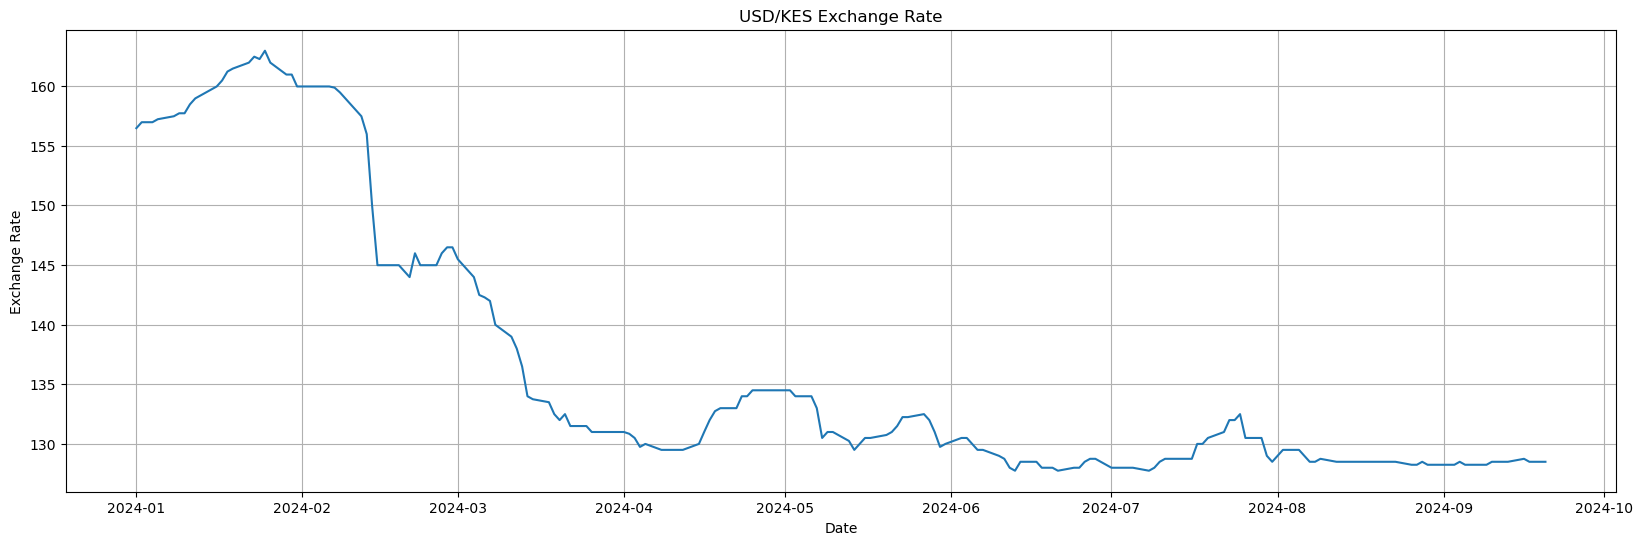

<Figure size 640x480 with 0 Axes>

In [143]:
# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(df['Close'])
plt.title('USD/KES Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [21]:
# Resample the data to include all the days
daily_data = df.resample('D').last()

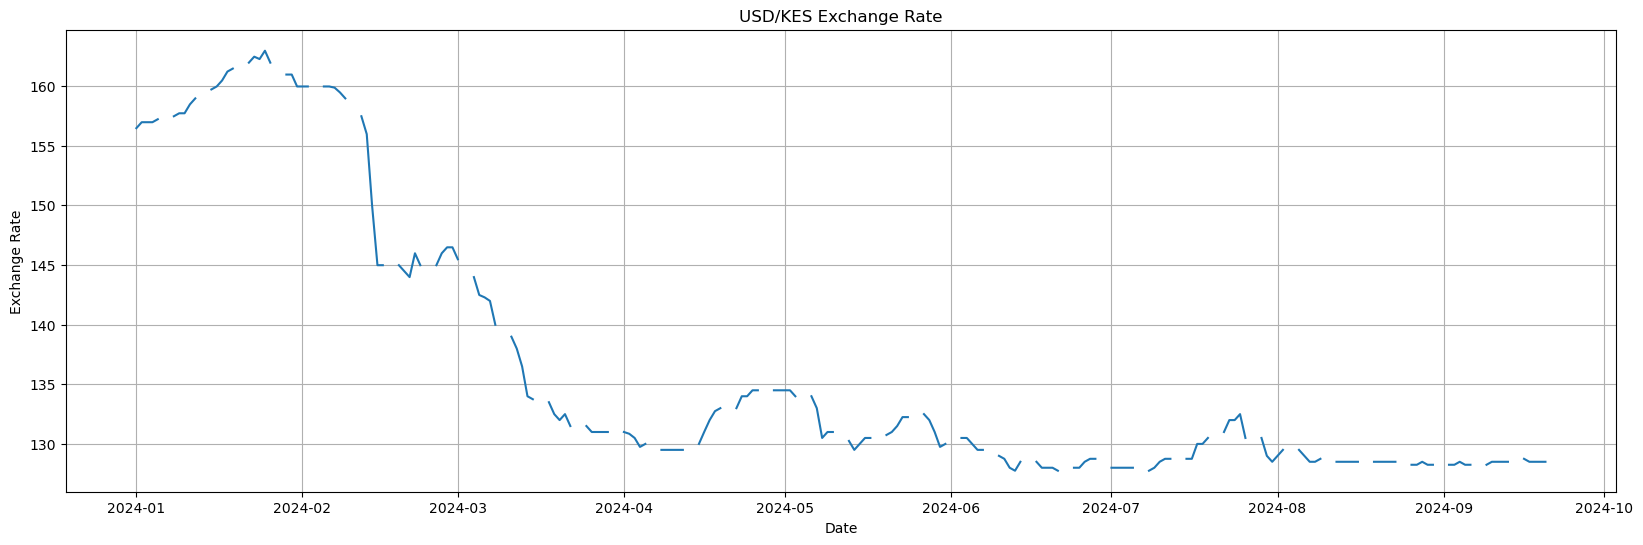

<Figure size 640x480 with 0 Axes>

In [145]:
# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(daily_data['Close'])
plt.title('USD/KES Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [146]:
# interpolate the data to include weekends
filled_data = daily_data.interpolate(method='linear')

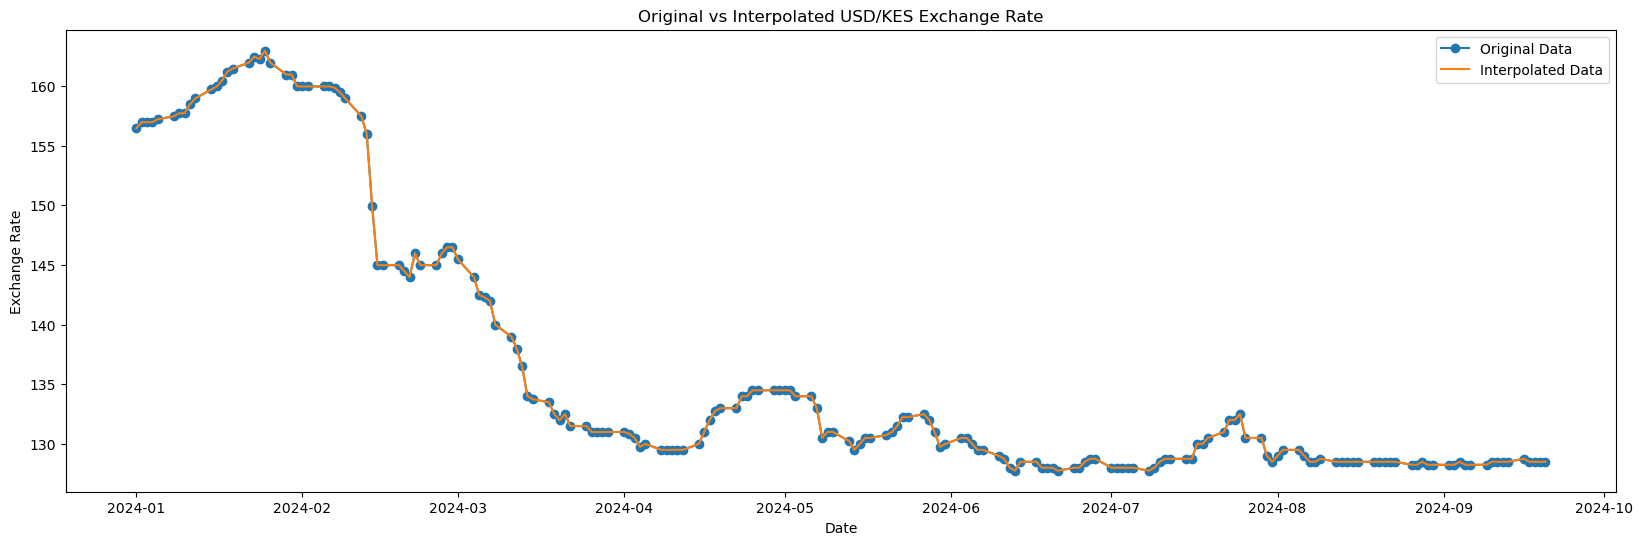

<Figure size 640x480 with 0 Axes>

In [147]:
# Plot original vs filled data
plt.figure(figsize=(20, 6))
plt.plot(df.index, df['Close'], label='Original Data', marker='o')
plt.plot(filled_data.index, filled_data['Close'], label='Interpolated Data')
plt.title('Original vs Interpolated USD/KES Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# Stationarity Check

In [148]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(filled_data['Close'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# If p-value > 0.05, the series is non-stationary
if adf_test[1] > 0.05:
    print("The series is non-stationary, differencing is required.")
else:
    print("The series is stationary.")

ADF Statistic: -1.745124040889179
p-value: 0.4080258641747029
The series is non-stationary, differencing is required.


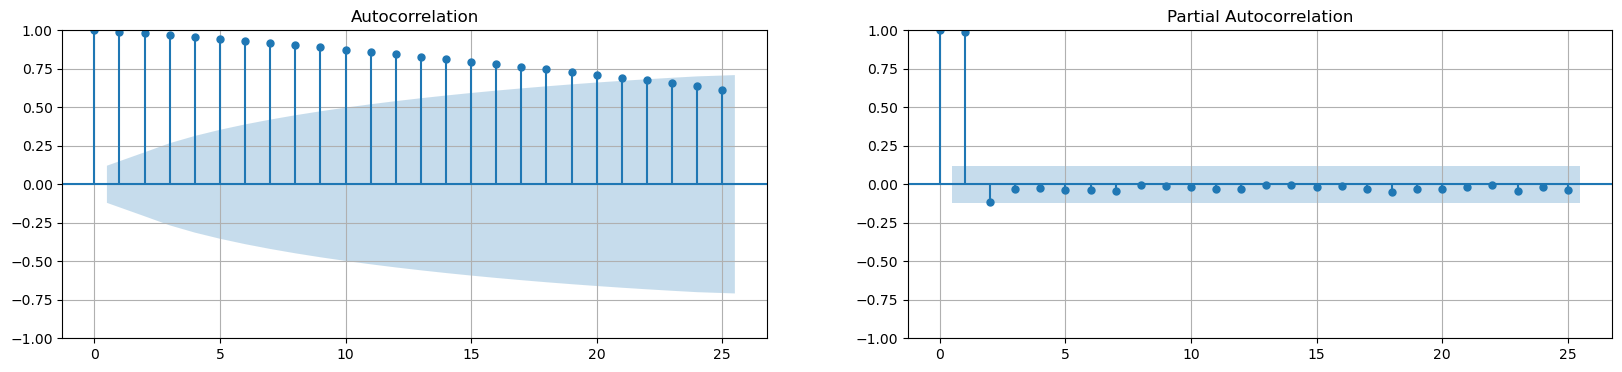

<Figure size 640x480 with 0 Axes>

In [149]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
plot_acf(filled_data, ax=axes[0])
axes[0].grid(True)
plot_pacf(filled_data, ax=axes[1])
axes[1].grid(True)
plt.show()

ACF is not deminishing

#  Prepare data for modeling

## Split the filled data into train and test sets

In [150]:
# Split the filled data into train and test sets
train_size = int(len(filled_data) * 0.95)
train, test = filled_data[:train_size], filled_data[train_size:]

In [151]:
print("Train: ",train.shape)
print("Test : ",test.shape)

Train:  (250, 1)
Test :  (14, 1)


## Decomposition

In [152]:
add_decomp = seasonal_decompose(train, model="additive")

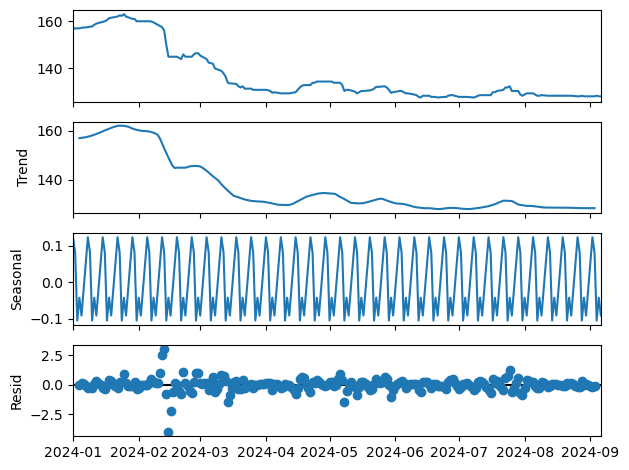

<Figure size 640x480 with 0 Axes>

In [153]:
add_decomp.plot()
plt.show()

- there is a trend in the data
- the data is also seasonal
- there is also White noise

## Augmented Dickey-Fuller (ADF) test 

In [154]:
adf_results = sts.adfuller(train)
#adf_results

In [155]:
adf_statistic = adf_results[0]
p_value = adf_results[1]
usedlag = adf_results[2]
nobs = adf_results[3]
critical_values = adf_results[4]
icbest = adf_results[5]

In [156]:
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Number of Lags Used:', usedlag)
print('Number of Observations Used:', nobs)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'\t{key}: {value}')

ADF Statistic: -1.647113596935681
p-value: 0.4585462009558655
Number of Lags Used: 1
Number of Observations Used: 248
Critical Values:
	1%: -3.4569962781990573
	5%: -2.8732659015936024
	10%: -2.573018897632674


Based on the ADF test results, 

- Test statistic: The ADF statistic is higher (less negative) than all the critical values.
- p-value: The p-value is greater than the common significance levels (0.01, 0.05, and 0.10).
- Stationarity: Given that the test statistic is higher than the critical values and the p-value is greater than 0.05, we fail to reject the null hypothesis of a unit root. This suggests that the time series is likely non-stationary.
- Critical values: Since the test statistic is less negative than all these critical values, it supporting the conclusion of non-stationarity.
- Sample size: Is a relatively large sample size, lending reliability to the results.
- Lag selection: 28 lags were used in the test, which helps account for potential autocorrelation in the residuals.

In conclusion, this time series appears to be non-stationary based on the ADF test results. Further differencing or transformation is necessary to achieve stationarity before proceeding with certain time series analyses or models.

# Modeling


## Differencing the Series

In [157]:
diff = train.diff().dropna()

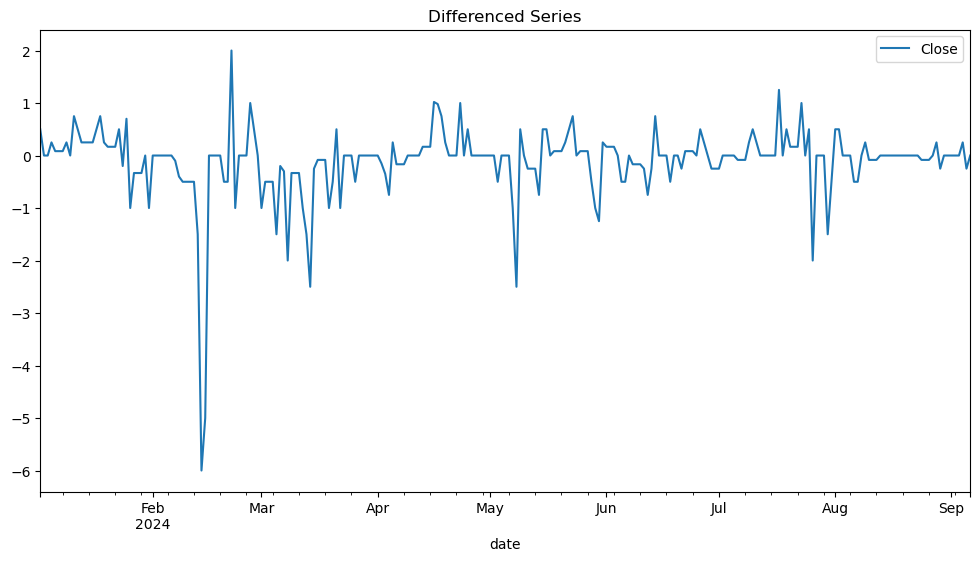

In [158]:
# Plot the differenced series
diff.plot(figsize=(12, 6))
plt.title('Differenced Series')
plt.show()

In [159]:
# Perform the ADF test on the differenced series
adf_result_diff = adfuller(diff)
print('ADF Statistic after Differencing:', adf_result_diff[0])
print('p-value after Differencing:', adf_result_diff[1])
print('Number of Lags Used:', adf_result_diff[2])
print('Number of Observations Used:', adf_result_diff[3])
print('Critical Values after Differencing:', adf_result_diff[4])

ADF Statistic after Differencing: -10.025982373176562
p-value after Differencing: 1.631645886977407e-17
Number of Lags Used: 0
Number of Observations Used: 248
Critical Values after Differencing: {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}


Deductions
- Since the p-value is now lower than 0.005 and the ADF statistic is more negative than the critical values indicate that the time series has become stationary after differencing. 
- Applying one difference (d=1) was sufficient to make the series stationary.

## Proceeding to identify the appropriate values for p and q by analyzing the ACF and PACF plots.

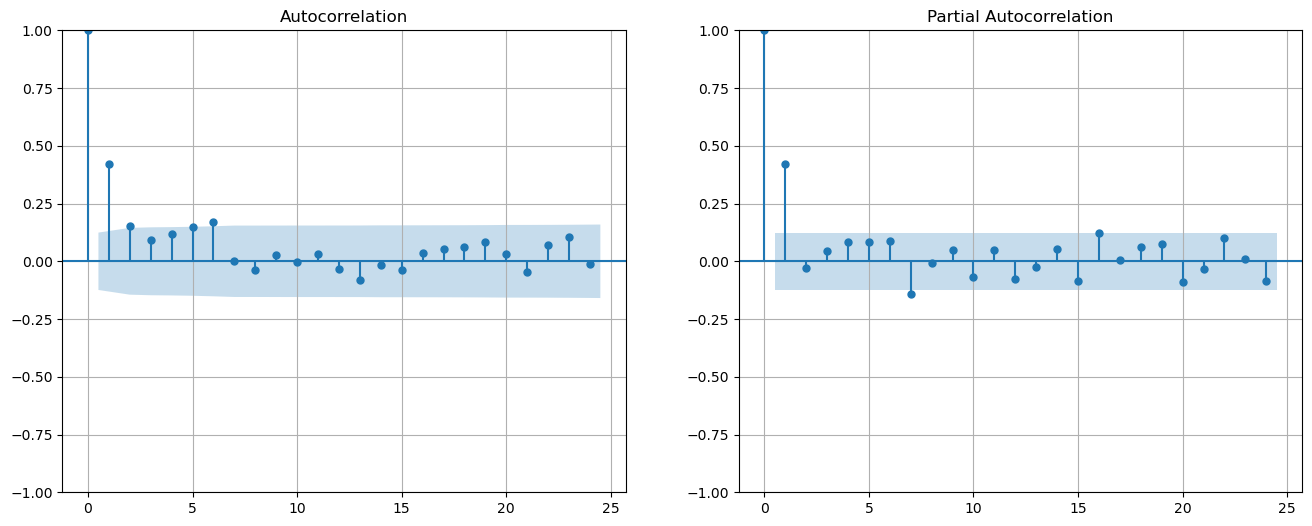

<Figure size 640x480 with 0 Axes>

In [160]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(diff, ax=axes[0])
axes[0].grid(True)
plot_pacf(diff, ax=axes[1])
axes[1].grid(True)
plt.show()

- p = 1
- d = 1
- q = 1
- m = 7

# Model selection

## 1. ARIMA

In [161]:
from statsmodels.tsa.arima.model import ARIMA

# Replace p, d, q with the values identified from ACF and PACF
model = ARIMA(train, order=(2, 1, 1))
model_fit = model.fit()

In [162]:
# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  250
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -245.351
Date:                Fri, 20 Sep 2024   AIC                            498.703
Time:                        17:04:42   BIC                            512.772
Sample:                    01-01-2024   HQIC                           504.366
                         - 09-06-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1488      2.594      0.057      0.954      -4.934       5.232
ar.L2          0.1020      1.146      0.089      0.929      -2.144       2.348
ma.L1          0.2989      2.590      0.115      0.9

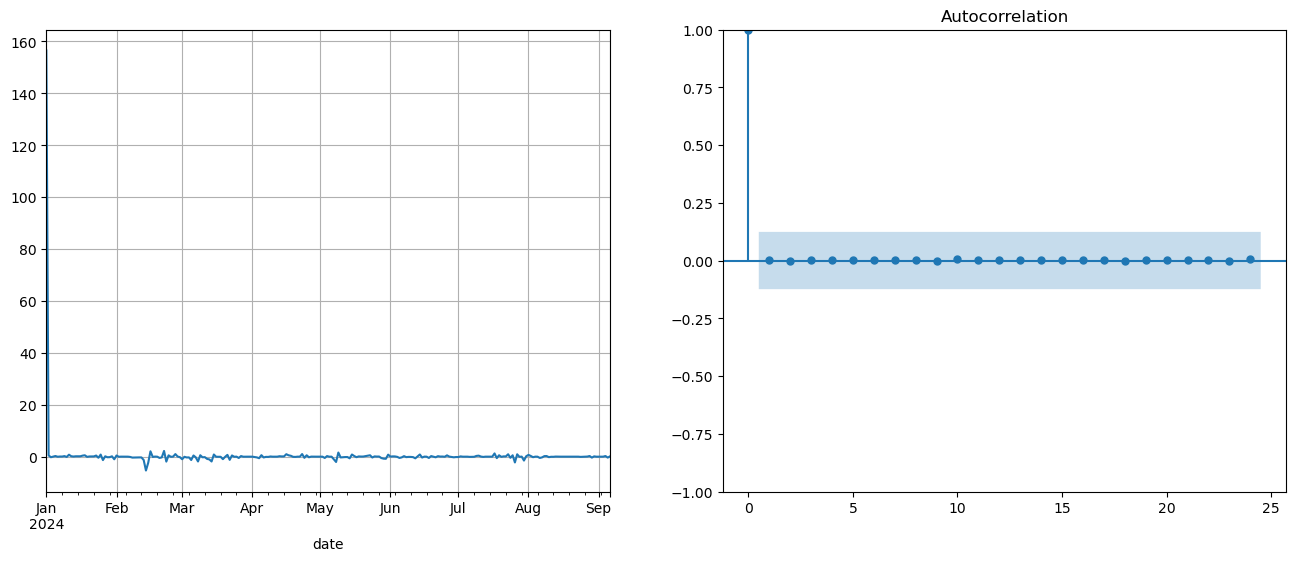

<Figure size 640x480 with 0 Axes>

In [163]:
residuals = model_fit.resid

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Plot residuals
residuals.plot(ax=axes[0])
axes[0].grid(True)
# Plot ACF of residuals
plot_acf(residuals, ax=axes[1])
plt.show()

In [164]:
predictions = model_fit.predict(start=len(train), end=len(train)+ len(test)-1, dynamic=True)

In [165]:
# Calculate Mean Squared Error
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.06769563510314407


In [166]:
# Calculate RMSE
rmse = mean_squared_error(test, predictions, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.26018384865925875


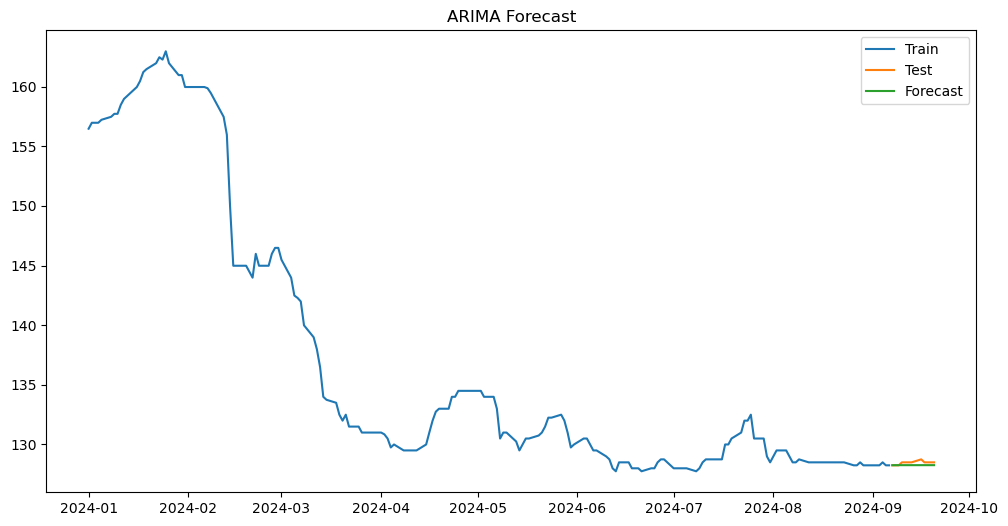

<Figure size 640x480 with 0 Axes>

In [168]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

## 2. SARIMA


In [169]:
p, d, q = 1, 1, 1

In [170]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_s = SARIMAX(train, order=(p, d, q), seasonal_order=(p, d, q, 7))  
fitted = model_s.fit() 


In [171]:
print(fitted.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  250
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -249.985
Date:                           Fri, 20 Sep 2024   AIC                            509.970
Time:                                   17:06:09   BIC                            527.415
Sample:                               01-01-2024   HQIC                           516.998
                                    - 09-06-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3660      0.095      3.866      0.000       0.180       0.552
ma.L1          0.0898      0.125      0.719

In [172]:
from sklearn.metrics import mean_squared_error
# Get the predicted values
predictions2 = fitted.predict(start=len(train), end=len(train)+ len(test)-1, dynamic=True)

In [173]:
# Calculate Mean Squared Error
mse = mean_squared_error(test, predictions2)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.910004119888856


In [174]:
# Calculate RMSE
rmse = mean_squared_error(test, predictions2, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.95394136082301


In [175]:
test.tail()

,Close
date,
2024-09-16,128.73
2024-09-17,128.48
2024-09-18,128.48
2024-09-19,128.48
2024-09-20,128.48


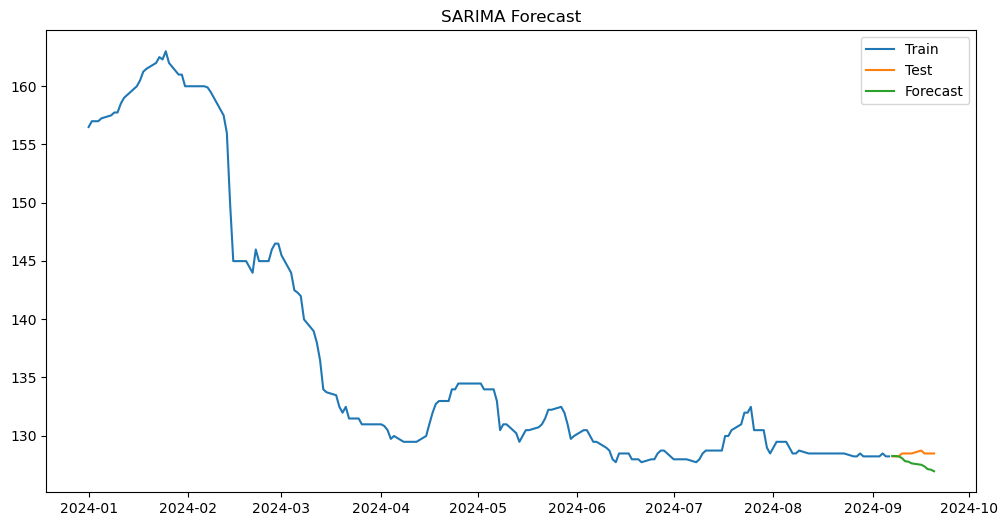

<Figure size 640x480 with 0 Axes>

In [176]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions2, label='Forecast')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

## 3. LSTM Model

In [177]:
close_data = original_data[['Close']].loc['2019':] 
dates = close_data.index               # Extracting dates from the DataFrame

In [178]:
close_values = close_data.values     # Convert the 'Close' column to NumPy array for processing

Data Preprocessing

In [179]:
scaler = MinMaxScaler(feature_range=(0, 1))       # Normalize the data using MinMaxScaler
scaled_data = scaler.fit_transform(close_values)

In [180]:
# Function to create sequences of data (X, y) pairs
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [181]:
time_step = 60                                      # Define time step for the sequences
X, y = create_sequences(scaled_data, time_step)     # Create sequences
X = X.reshape((X.shape[0], X.shape[1], 1))          # Reshape X to be [samples, time steps, features] for LSTM

In [182]:
# Split data into training and testing sets (80% training, 20% testing)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [183]:
print("X_train shape is...", X_train.shape)
print("X_test shape is....", X_test.shape)
print("y_train shape is...", y_train.shape)
print("y_test shape is....", y_test.shape)

X_train shape is... (1146, 60, 1)
X_test shape is.... (287, 60, 1)
y_train shape is... (1146,)
y_test shape is.... (287,)


Splitting the dates accordingly

In [184]:
dates_train = dates[time_step:split + time_step]  # Adjust to match the training data length
dates_test = dates[split + time_step:]            # Adjust to match the test data length

Create the LSTM Model

In [185]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

In [186]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [187]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0225 - val_loss: 0.0024
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.3311e-04 - val_loss: 0.0027
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 8.8595e-05 - val_loss: 0.0027
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 7.3585e-05 - val_loss: 0.0031
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 7.8981e-05 - val_loss: 0.0025
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 7.2633e-05 - val_loss: 0.0024
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 8.0008e-05 - val_loss: 0.0026
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 6.6005e-05 - val_loss: 0.0027
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 6.8309e-05 - val_loss: 0.0023
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 7.9084e-05 - val_loss: 0.0023
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 7.5421e-05 - val_loss: 0.0023
Epoch 12/20
36/36 ━━━

In [188]:
# Make Predictions
predicted = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


In [189]:
# Inverse transform the predictions and actual values to original scale for comparison
predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

Predicting the future

In [190]:
future_days = 14

In [191]:
last_sequence = X_test[-1]  # last sequence from the test set

Make predictions for the next 'future_days'

In [192]:
future_predictions = []
current_sequence = last_sequence

for i in range(future_days):
    next_value = model.predict(current_sequence.reshape(1, time_step, 1))   # Predict the next value
    future_predictions.append(next_value[0, 0])                             # Append the prediction to the future predictions list
    current_sequence = np.append(current_sequence[1:], next_value, axis=0)  # Update the current sequence by removing the first element and adding the new prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [193]:
# Scale back the predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Generating future dates for the next 14 days

In [194]:
last_date = dates_test[-1]  # Last date from the test set
future_dates = [last_date + timedelta(days=i) for i in range(1, future_days + 1)]

Plotting 

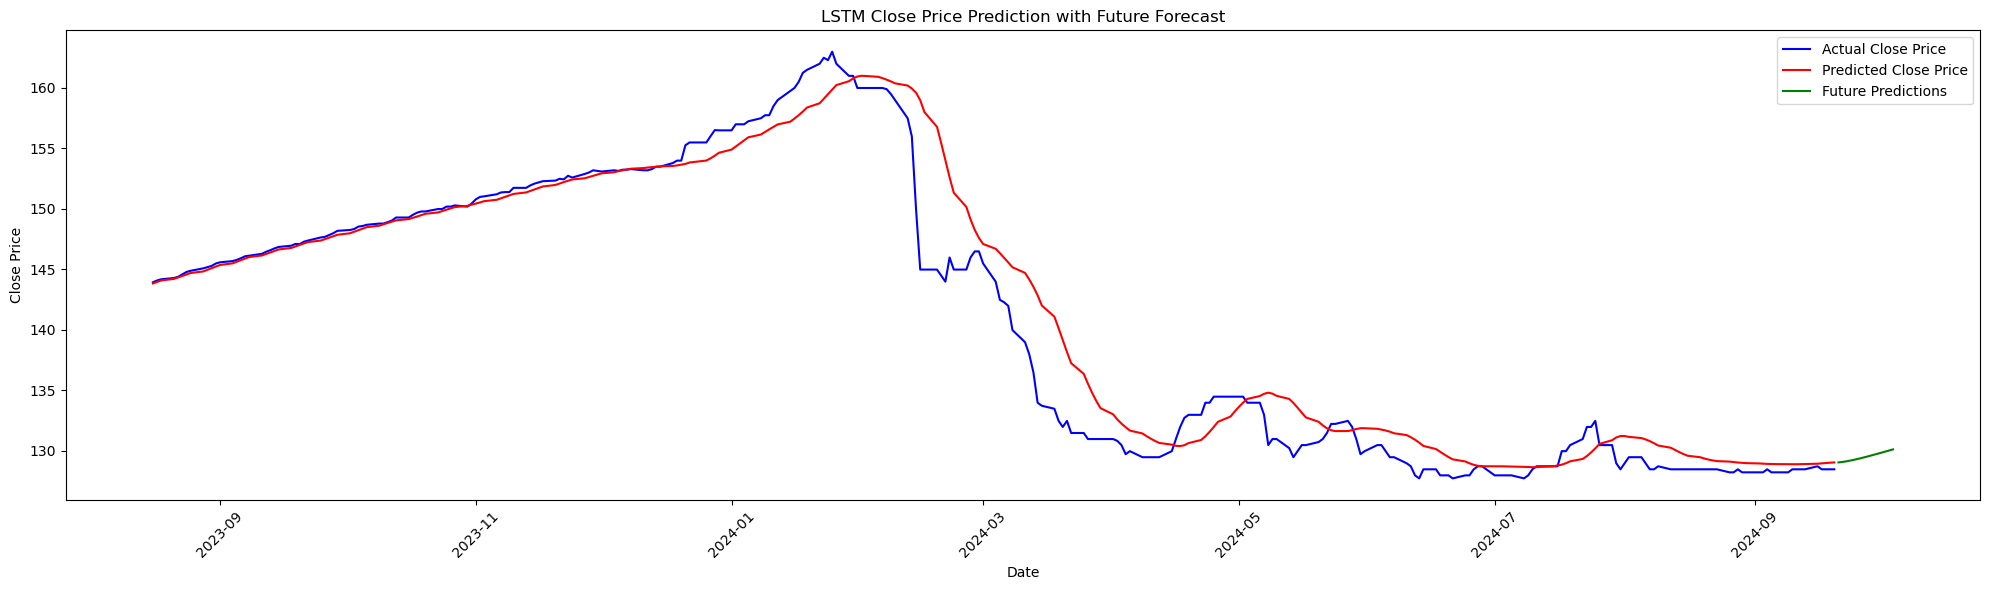

<Figure size 640x480 with 0 Axes>

In [195]:
plt.figure(figsize=(20, 6))

plt.plot(dates_test, y_test_scaled, color='blue', label='Actual Close Price')
plt.plot(dates_test, predicted, color='red', label='Predicted Close Price')
plt.plot(future_dates, future_predictions, color='green', label='Future Predictions')

plt.title('LSTM Close Price Prediction with Future Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [196]:
print(len(future_predictions))
print(len(future_dates))

14
14


In [197]:
future_predictions = np.array(future_predictions).flatten()    # Ensuring that the arrays are 1-dimensional
future_dates = np.array(future_dates).flatten()

df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions
})
df['Date'] = pd.to_datetime(df['Date'])
print(df)

         Date  Predicted_Close
0  2024-09-21       129.049591
1  2024-09-22       129.090942
2  2024-09-23       129.146606
3  2024-09-24       129.213501
4  2024-09-25       129.288956
5  2024-09-26       129.370865
6  2024-09-27       129.457565
7  2024-09-28       129.547791
8  2024-09-29       129.640564
9  2024-09-30       129.735229
10 2024-10-01       129.831284
11 2024-10-02       129.928406
12 2024-10-03       130.026352
13 2024-10-04       130.124985


In [198]:
rmse = np.sqrt(mean_squared_error(y_test_scaled, predicted))
print("RMSE for the LSTM model: ",rmse)

RMSE for the LSTM model:  2.7150686564824174


# USD TO UGX

In [199]:
# Get the daily exchange rates
data2, meta_data = fx.get_currency_exchange_daily(from_symbol="USD", to_symbol="UGX", outputsize="full")

In [200]:
# Renaming columns
data2.rename(columns={
    "1. open": "Open",
    "2. high": "High",
    "3. low": "Low",
    "4. close": "Close"
}, inplace=True)

In [201]:
data2 = data2.sort_index()

In [202]:
df2 = data2.loc['2024':]

In [203]:
df2.head()

,Open,High,Low,Close
date,,,,
2024-01-01,3777.2,3777.2,3777.2,3777.2
2024-01-02,3777.2,3777.2,3776.8,3776.8
2024-01-03,3776.8,3801.8,3776.8,3801.8
2024-01-04,3801.8,3801.8,3797.5,3797.5
2024-01-05,3797.5,3797.5,3787.4,3787.4


In [204]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 189 entries, 2024-01-01 to 2024-09-20
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    189 non-null    float64
 1   High    189 non-null    float64
 2   Low     189 non-null    float64
 3   Close   189 non-null    float64
dtypes: float64(4)
memory usage: 7.4 KB


In [205]:
df2 = df2["Close"]
df2 = pd.DataFrame(data=df2)

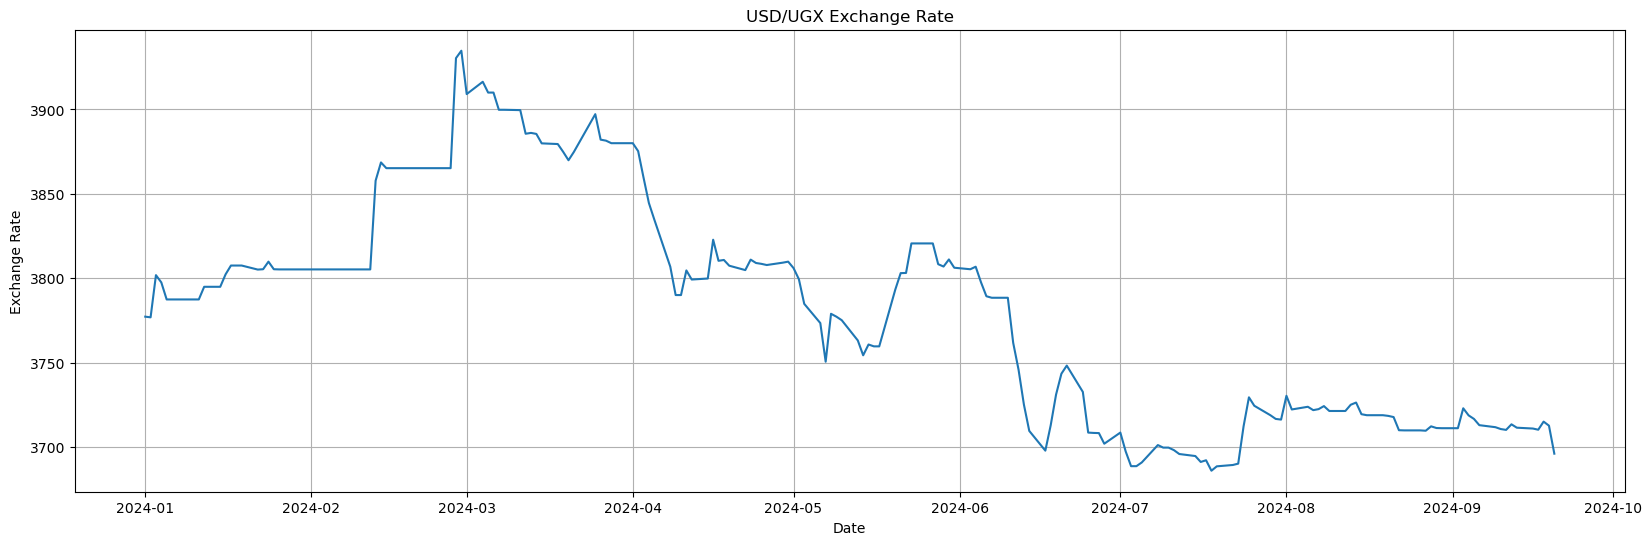

<Figure size 640x480 with 0 Axes>

In [206]:
# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(df2['Close'])
plt.title('USD/UGX Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [207]:
# Resample the data to include all the days
daily_df = df2.resample('D').last()

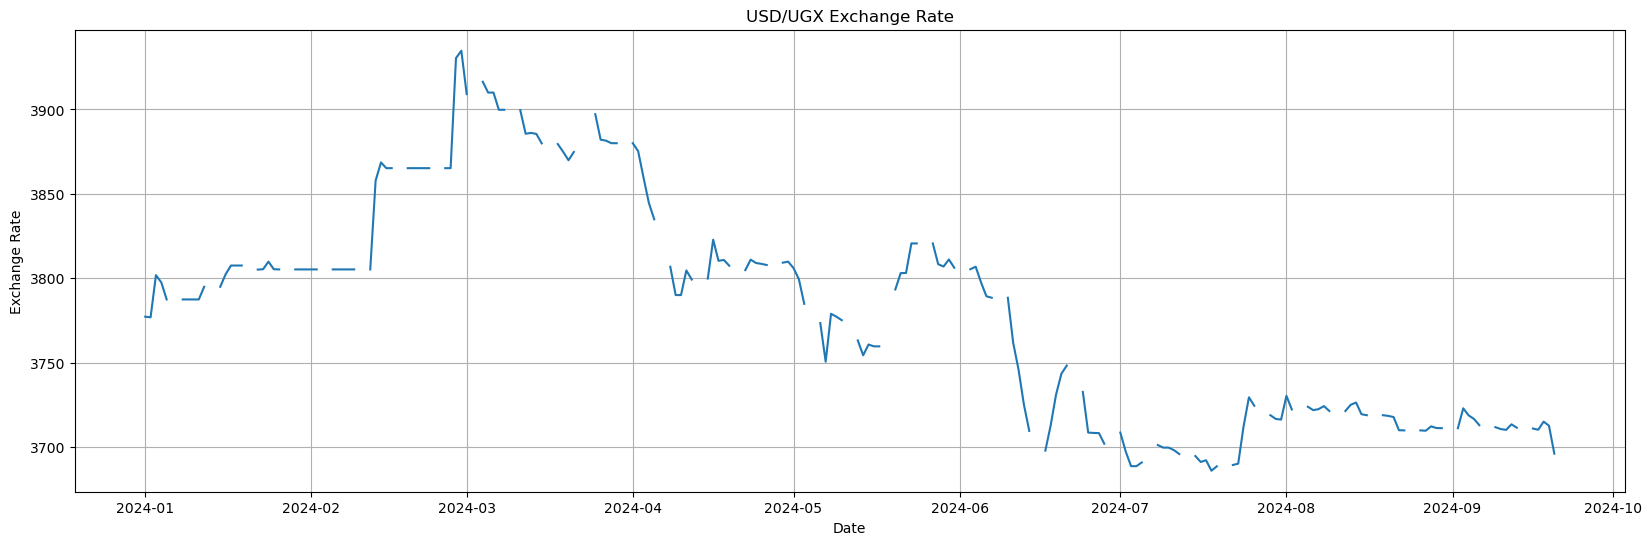

In [208]:
# Plot the data
plt.figure(figsize=(20, 6))
plt.plot(daily_df['Close'])
plt.title('USD/UGX Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [209]:
# interpolate the data to include weekends
filled_df = daily_df.interpolate(method='linear')

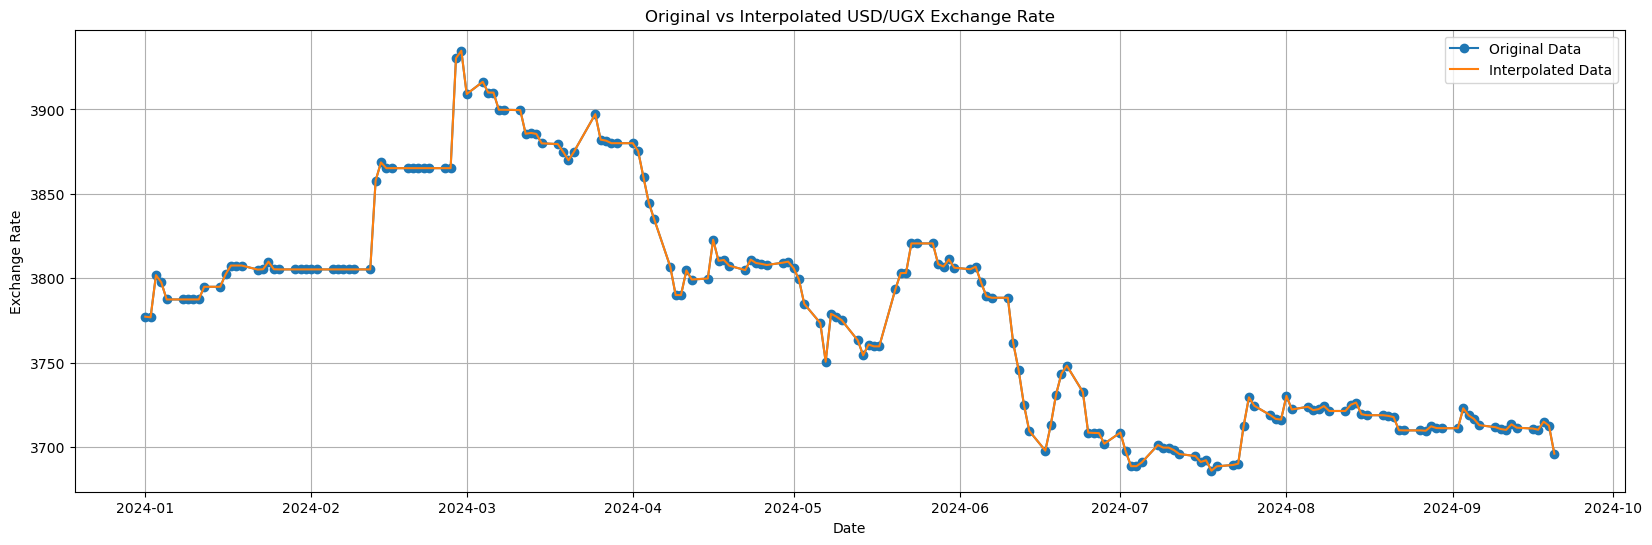

<Figure size 640x480 with 0 Axes>

In [211]:
# Plot original vs filled data
plt.figure(figsize=(20, 6))
plt.plot(df2.index, df2['Close'], label='Original Data', marker='o')
plt.plot(filled_df.index, filled_df['Close'], label='Interpolated Data')
plt.title('Original vs Interpolated USD/UGX Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.legend()
plt.show()

In [212]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(filled_df['Close'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# If p-value > 0.05, the series is non-stationary
if adf_test[1] > 0.05:
    print("The series is non-stationary, differencing is required.")
else:
    print("The series is stationary.")

ADF Statistic: -0.9111766810299323
p-value: 0.7842694966040384
The series is non-stationary, differencing is required.


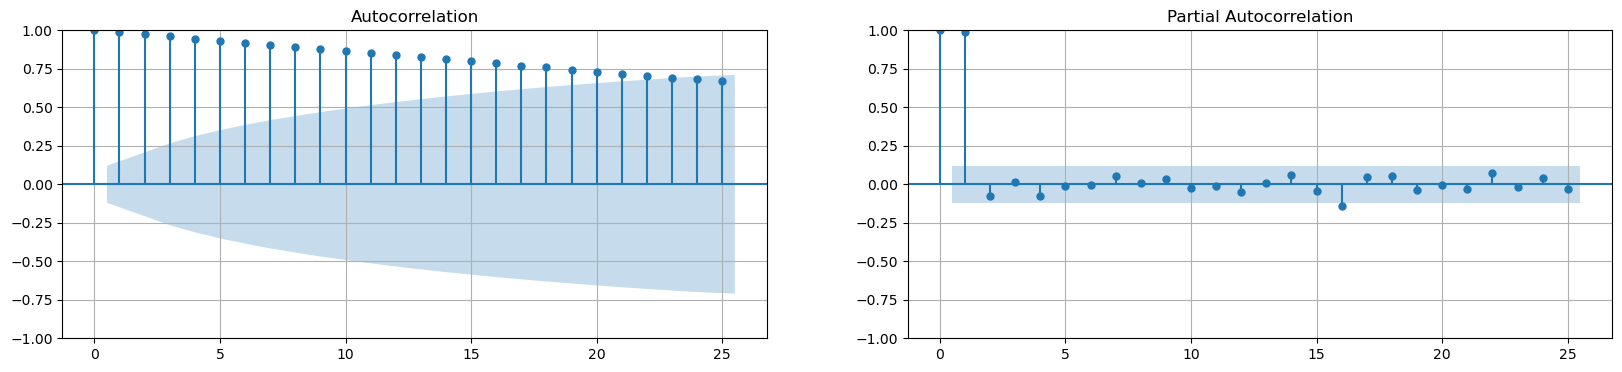

In [213]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
plot_acf(filled_df, ax=axes[0])
axes[0].grid(True)
plot_pacf(filled_df, ax=axes[1])
axes[1].grid(True)
plt.show()

In [214]:
# Split the filled data into train and test sets
train_size2 = int(len(filled_df) * 0.95)
train2, test2 = filled_df[:train_size2], filled_df[train_size2:]

In [215]:
print("Train: ",train2.shape)
print("Test : ",test2.shape)

Train:  (250, 1)
Test :  (14, 1)


In [216]:
add_decomp2 = seasonal_decompose(train2, model="additive")

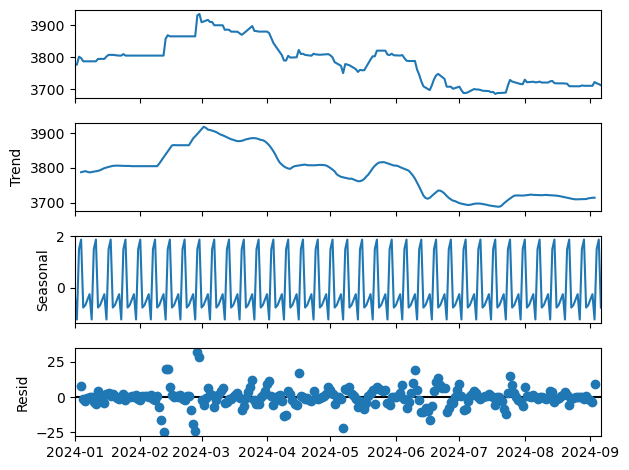

In [217]:
add_decomp2.plot()
plt.show()

In [218]:
import statsmodels.tsa.stattools as sts
adf_results2 = sts.adfuller(train2)
#adf_results

In [219]:
adf_statistic = adf_results2[0]
p_value = adf_results2[1]
usedlag = adf_results2[2]
nobs = adf_results2[3]
critical_values = adf_results2[4]
icbest = adf_results2[5]

print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Number of Lags Used:', usedlag)
print('Number of Observations Used:', nobs)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'\t{key}: {value}')


ADF Statistic: -1.0240537919232295
p-value: 0.7443904580247946
Number of Lags Used: 1
Number of Observations Used: 248
Critical Values:
	1%: -3.4569962781990573
	5%: -2.8732659015936024
	10%: -2.573018897632674


In [220]:
diff2 = train2.diff().dropna()

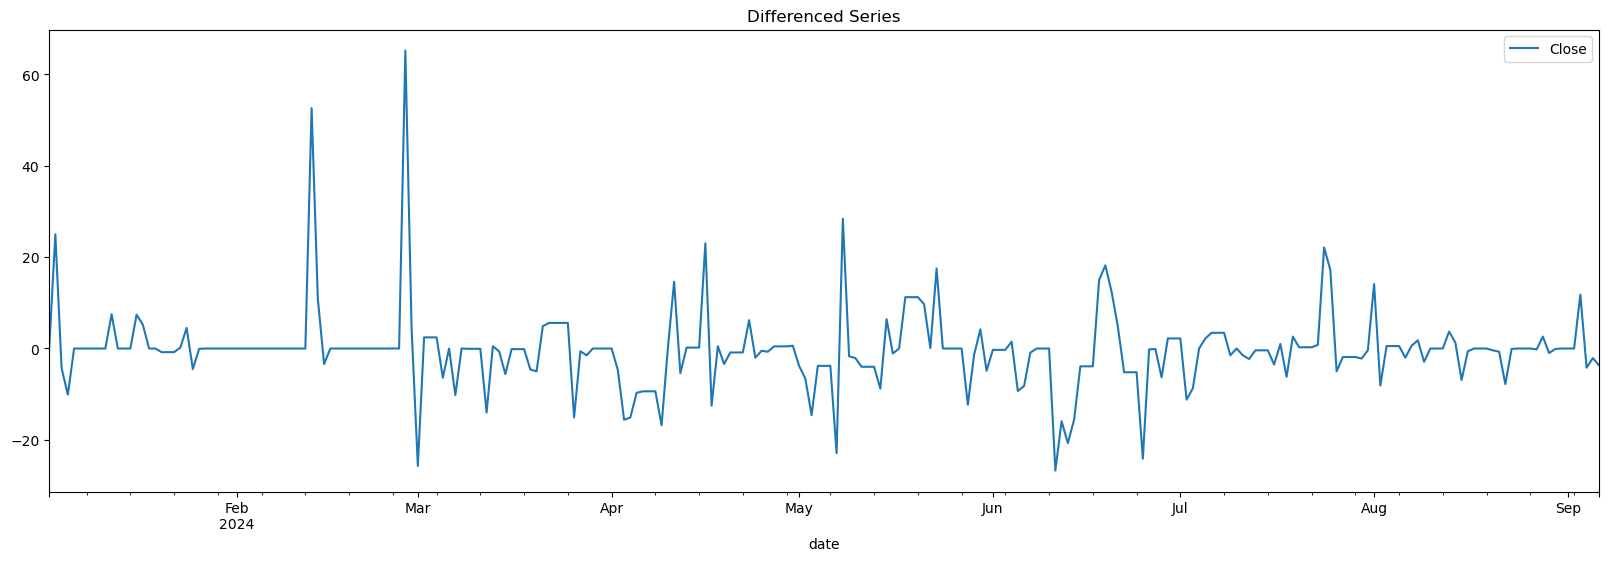

In [221]:
# Plot the differenced series
diff2.plot(figsize=(20, 6))
plt.title('Differenced Series')
plt.show()

In [222]:
# Perform the ADF test on the differenced series
adf_result_diff2 = adfuller(diff2)
print('ADF Statistic after Differencing:', adf_result_diff2[0])
print('p-value after Differencing:', adf_result_diff2[1])
print('Number of Lags Used:', adf_result_diff2[2])
print('Number of Observations Used:', adf_result_diff2[3])
print('Critical Values after Differencing:', adf_result_diff2[4])

ADF Statistic after Differencing: -13.268207512061743
p-value after Differencing: 8.1370894301947555e-25
Number of Lags Used: 0
Number of Observations Used: 248
Critical Values after Differencing: {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}


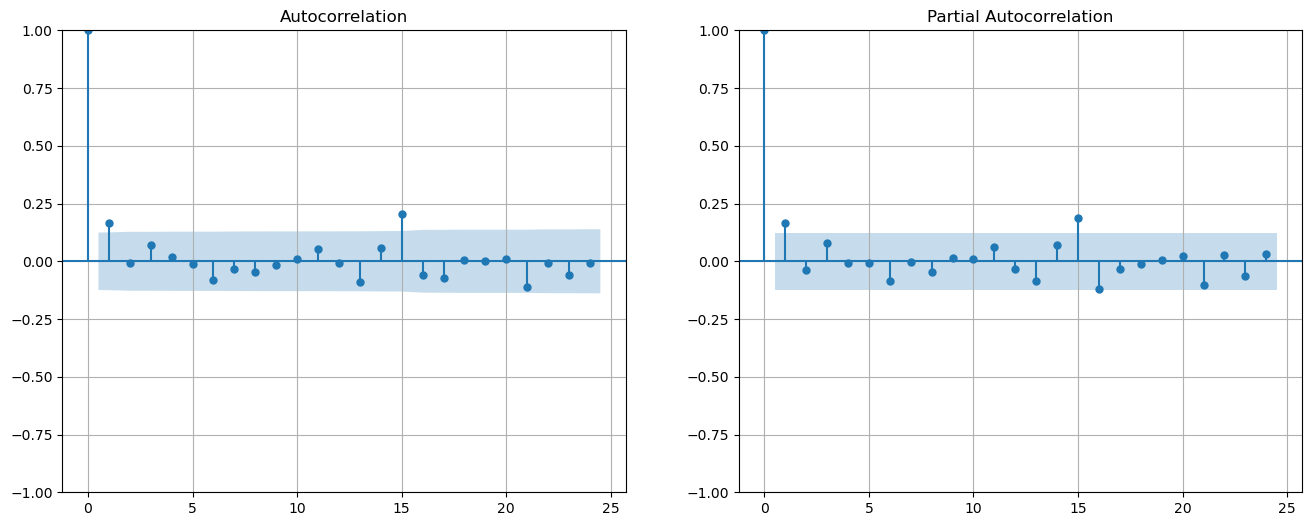

In [223]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(diff2, ax=axes[0])
axes[0].grid(True)
plot_pacf(diff2, ax=axes[1])
axes[1].grid(True)
plt.show()

In [224]:
# Replace p, d, q with the values identified from ACF and PACF
model2 = ARIMA(train2, order=(5, 1, 1))
model_fit2 = model2.fit()

In [225]:
predict = model_fit2.predict(start=len(train2), end=len(train2)+ len(test2)-1, dynamic=True)

In [226]:
predict

2024-09-07    3711.910377
2024-09-08    3711.778119
2024-09-09    3711.514730
2024-09-10    3711.422986
2024-09-11    3711.419668
2024-09-12    3711.403141
2024-09-13    3711.394862
2024-09-14    3711.394892
2024-09-15    3711.394004
2024-09-16    3711.393281
2024-09-17    3711.393281
2024-09-18    3711.393248
2024-09-19    3711.393188
2024-09-20    3711.393185
Freq: D, Name: predicted_mean, dtype: float64

In [227]:
# Calculate Mean Squared Error
mse2 = mean_squared_error(test2, predict)
print(f'Mean Squared Error: {mse2}')

Mean Squared Error: 18.579113984842504


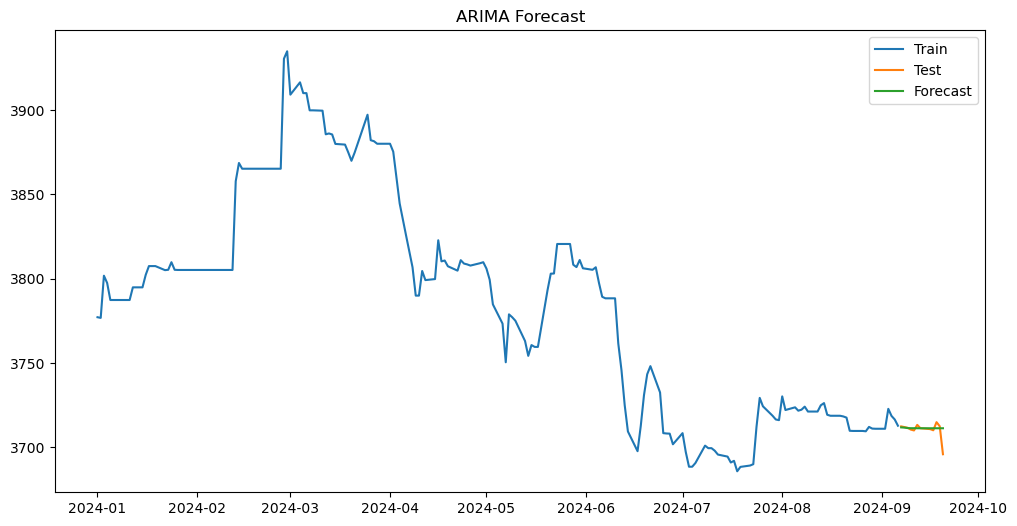

<Figure size 640x480 with 0 Axes>

In [228]:
plt.figure(figsize=(12, 6))
plt.plot(train2.index, train2, label='Train')
plt.plot(test2.index, test2, label='Test')
plt.plot(test2.index, predict, label='Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [229]:
p,d,q = 1,1,1

In [230]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_s2 = SARIMAX(train2, order=(p, d, q), seasonal_order=(p, d, q, 7))  
fitted2 = model_s2.fit() 


In [231]:
# Get the predicted values
predict2 = fitted2.predict(start=len(train2), end=len(train2)+ len(test2)-1, dynamic=True)

In [232]:
predict2

2024-09-07    3712.247575
2024-09-08    3712.288122
2024-09-09    3712.077545
2024-09-10    3710.566861
2024-09-11    3713.799129
2024-09-12    3713.493145
2024-09-13    3710.591585
2024-09-14    3710.459155
2024-09-15    3710.351611
2024-09-16    3710.187965
2024-09-17    3708.927276
2024-09-18    3712.016626
2024-09-19    3711.674225
2024-09-20    3708.757228
Freq: D, Name: predicted_mean, dtype: float64

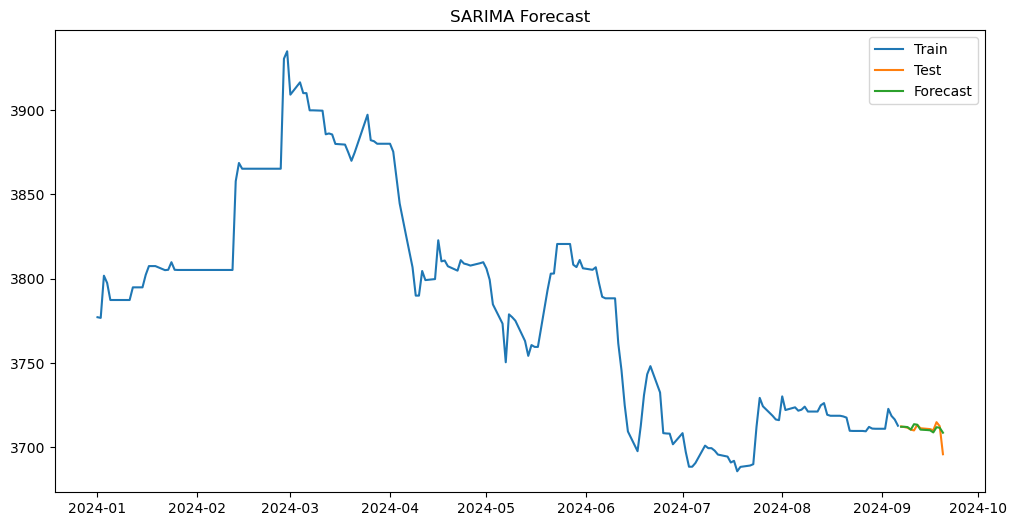

<Figure size 640x480 with 0 Axes>

In [233]:
plt.figure(figsize=(12, 6))
plt.plot(train2.index, train2, label='Train')
plt.plot(test2.index, test2, label='Test')
plt.plot(test2.index, predict2, label='Forecast')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [234]:
# Ensure 'Close' is a numpy array of the right shape
data2 = data2[['Close']].values

Data Preprocessing

In [235]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data2)

In [236]:
# Function to create sequences of data (X, y) pairs
def create_sequences(data2, time_step=60):
    X, y = [], []
    for i in range(len(data2) - time_step):
        X.append(data2[i:i + time_step, 0])
        y.append(data2[i + time_step, 0])
    return np.array(X), np.array(y)

In [237]:
# Define time step for the sequences
time_step = 60

In [238]:
# Create sequences
X, y = create_sequences(scaled_data, time_step)

In [239]:
# Reshape X to be [samples, time steps, features] for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

In [240]:

# Split data into training and testing sets (80% training, 20% testing)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [241]:
print("X_train shape is...", X_train.shape)
print("X_test shape is....", X_test.shape)
print("y_train shape is...", y_train.shape)
print("y_test shape is....", y_test.shape)

X_train shape is... (2009, 60, 1)
X_test shape is.... (503, 60, 1)
y_train shape is... (2009,)
y_test shape is.... (503,)


In [242]:
# Step 4: Create the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

In [243]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [244]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.1037 - val_loss: 0.0012
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0014 - val_loss: 4.7813e-04
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 9.0676e-04 - val_loss: 4.6414e-04
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 7.5212e-04 - val_loss: 4.5761e-04
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 7.5800e-04 - val_loss: 4.4531e-04
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 7.2260e-04 - val_loss: 4.1433e-04
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 6.9024e-04 - val_loss: 4.5960e-04
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 7.6631e-04 - val_loss: 3.8595e-04
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 7.0289e-04 - val_loss: 3.7056e-04
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 6.5936e-04 - val_loss: 3.7118e-04
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 7.2938e-04 - val_los

In [245]:
# Step 5: Make Predictions
predicted = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


In [246]:
# Inverse transform the predictions to original scale
predicted = scaler.inverse_transform(predicted.reshape(-1, 1))

In [247]:
# Inverse transform the actual values for comparison
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

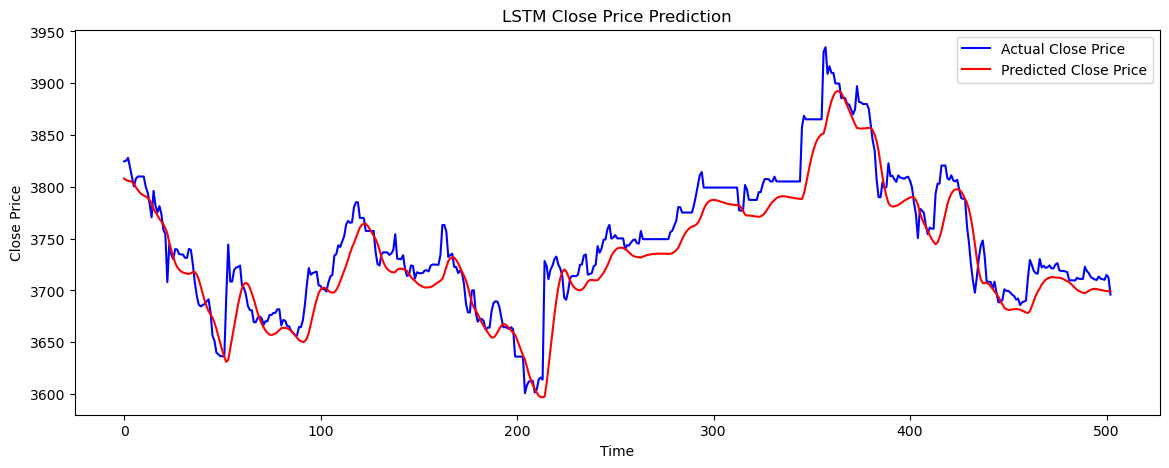

<Figure size 640x480 with 0 Axes>

In [248]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(y_test_scaled, color='blue', label='Actual Close Price')
plt.plot(predicted, color='red', label='Predicted Close Price')
plt.title('LSTM Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()